In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

The goal of this notebook is to explore the difference between the structure matrices computed using the full mammalia reference versus the one computed using primates only, in order to compose the different elements of Fig3.

## helper function

In [2]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    if len(col_labels)>0:
        ax.set_xticks(np.arange(data.shape[1]))
        ax.set_yticks(np.arange(data.shape[0]))
        # ... and label them with the respective list entries.
        ax.set_xticklabels(col_labels)
        ax.set_yticklabels(row_labels)


        # Let the horizontal axes labeling appear on top.
        ax.tick_params(top=True, bottom=False,
                       labeltop=True, labelbottom=False)
    
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
                 rotation_mode="anchor")
        ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
        ax.tick_params(which="minor", bottom=False, left=False)
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    # Turn spines off and create white grid.
    #for edge, spine in ax.spines.items():
    #    spine.set_visible(False)

    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)

    return im, cbar



In [3]:

def yieldStructureMatrix_bin( inHandle ):
	"""

	Takes:
		- inHandle : input binary handle

	Yield:
		str : sequence name
		numpy array : correlation of the sequence with some others 
					(corresponding to a line in the lower triangular matrix)
	"""

	i = 0
	name = inHandle.readline().decode('ascii').strip()
	while name:
		arr = np.fromfile( inHandle , dtype=np.float64 , count = i )
		yield name, arr
		i+=1
		name = inHandle.readline().decode('ascii').strip()

def readStructureMatrix_bin( pth ):
	"""

	Takes:
		- pth : str. name of the file to read

	Yield:
		list : list contnaing sequence names
		numpy array :  2D structure matrix

	"""

	seqList = []
	lines = []

	with open( pth , 'rb' ) as IN:
		for h,x in yieldStructureMatrix_bin( IN ):
			
			seqList.append(h)
			lines.append(x)

	M = np.ones( ( len(lines) , len(lines) ) )

	for i,l in enumerate( lines ):
		M[i,:i] = l
		M[:i,i] = l

	return seqList,M


# Fig3 A :  primates-only experiment structure matrices comparison

## 1. read the matrices

In [4]:
seqList_mammals,M_mammals = readStructureMatrix_bin('results/Mammalia_selected.Mammalia_selected_ref.stMat.bin')
seqList_primates,M_primates = readStructureMatrix_bin('results/Mammalia_selected.Primates_selected_ref.stMat.bin')

In [5]:
seqList_mammals == seqList_primates

True

## 2. set up the comparison

In [6]:
sid2sp = {}
sid2tax = {}

with open('sequenceList.csv','r') as IN:
    
    for l in IN:
        sl=l.strip().split(';')
        sid2sp[sl[-1]] = sl[1]
        sid2tax[sl[-1]] = sl[0]

In [7]:
data = { 'seqId1' : [],
         'seqId2' : [],
         'sp1': [],
         'sp2': [],
         'taxon1'  : [],
         'taxon2'  : [],
         'mam_ref' : [],
         'pri_ref' : []}

for i,seq1 in enumerate(seqList_mammals):
    for j,seq2 in enumerate(seqList_mammals):
        if j>=i:
            continue
    
        data['seqId1'].append(seq1)
        data['seqId2'].append(seq2)
        data['sp1'].append( sid2sp[seq1] )
        data['sp2'].append( sid2sp[seq2] )
        data['taxon1'].append( sid2tax[seq1] )
        data['taxon2'].append( sid2tax[seq2] )
        data['mam_ref'].append( M_mammals[i,j] )
        data['pri_ref'].append( M_primates[i,j] )


In [8]:
import pandas as pd
df = pd.DataFrame(data)
df['taxonCouple'] = df.taxon1 +'_'+ df.taxon2 
df.head()

,seqId1,seqId2,sp1,sp2,taxon1,taxon2,mam_ref,pri_ref,taxonCouple
0,GBMTG5358-16,GBMA6371-13,Cabassous unicinctus,Cabassous unicinctus,Xenarthra,Xenarthra,0.786138,0.790746,Xenarthra_Xenarthra
1,GBMNA13869-19,GBMA6371-13,Cabassous unicinctus,Cabassous unicinctus,Xenarthra,Xenarthra,0.786138,0.790746,Xenarthra_Xenarthra
2,GBMNA13869-19,GBMTG5358-16,Cabassous unicinctus,Cabassous unicinctus,Xenarthra,Xenarthra,1.000000,1.000000,Xenarthra_Xenarthra
3,GBMNA13876-19,GBMA6371-13,Tolypeutes matacus,Cabassous unicinctus,Xenarthra,Xenarthra,0.581221,0.603307,Xenarthra_Xenarthra
4,GBMNA13876-19,GBMTG5358-16,Tolypeutes matacus,Cabassous unicinctus,Xenarthra,Xenarthra,0.561968,0.587297,Xenarthra_Xenarthra


## 3. plotting structure matrix correlation

We will compute correlations for all values in the struture matrices, and aggregate them by taxon of interest

In [9]:
import scipy.stats as stats
taxonLabels = ['Prototheria','Metatheria','Afrotheria','Xenarthra',
               'Artiodactyla', 'Carnivora', 'Chiroptera', 'Eulipotyphla','Pholidota','Perissodactyla',
               'Dermoptera',  'Glires', 'Primates', 'Scandentia' ]

taxonCorrPearson = np.zeros( ( len(taxonLabels) , len(taxonLabels) ) )

for i,t1 in enumerate( taxonLabels ):
    for j,t2 in enumerate( taxonLabels ):
        
        m = ( df.taxon1 == t1 )&( df.taxon2 == t2 )|( df.taxon1 == t2 )&( df.taxon2 == t1 )        
        
        cc = np.corrcoef(df.loc[m,'mam_ref'],df.loc[m,'pri_ref'])
        taxonCorrPearson[i,j] = cc[0,1]
        

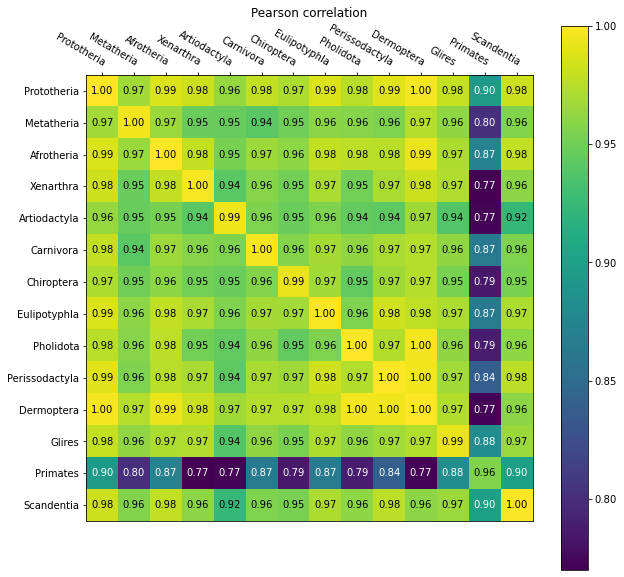

In [10]:
fig,ax = plt.subplots(1,1 , figsize=(10,10))

heatmap(taxonCorrPearson, taxonLabels, taxonLabels, ax=ax)
ax.set_title("Pearson correlation")
for i in range(len(taxonLabels)):
    for j in range(len(taxonLabels)):
        c = 'k'
        if taxonCorrPearson[i, j] < 0.9:
            c = 'w'
        text = ax.text(j, i, '{:.2f}'.format(taxonCorrPearson[i, j]) ,
                       ha="center", va="center", color=c)


# Fig3 B : noLaurasiatheria experiment - structure matrices comparison

## 1. read the matrices

In [11]:
seqList_mammals,M_mammals = readStructureMatrix_bin('results/Mammalia_selected.Mammalia_selected_ref.stMat.bin')
seqList_noLaurasia,M_noLaurasia = readStructureMatrix_bin('results/Mammalia_selected.noLaurasiaTheria_selected_ref.stMat.bin')

In [12]:
seqList_mammals == seqList_noLaurasia

True

## 2. set up the comparison

In [13]:
sid2sp = {}
sid2tax = {}

with open('sequenceList.csv','r') as IN:
    
    for l in IN:
        sl=l.strip().split(';')
        sid2sp[sl[-1]] = sl[1]
        sid2tax[sl[-1]] = sl[0]

In [14]:
data = { 'seqId1' : [],
         'seqId2' : [],
         'sp1': [],
         'sp2': [],
         'taxon1'  : [],
         'taxon2'  : [],
         'mam_ref' : [],
         'noL_ref' : []}

for i,seq1 in enumerate(seqList_mammals):
    for j,seq2 in enumerate(seqList_mammals):
        if j>=i:
            continue
    
        data['seqId1'].append(seq1)
        data['seqId2'].append(seq2)
        data['sp1'].append( sid2sp[seq1] )
        data['sp2'].append( sid2sp[seq2] )
        data['taxon1'].append( sid2tax[seq1] )
        data['taxon2'].append( sid2tax[seq2] )
        data['mam_ref'].append( M_mammals[i,j] )
        data['noL_ref'].append( M_noLaurasia[i,j] )


In [15]:
import pandas as pd
df = pd.DataFrame(data)
df['taxonCouple'] = df.taxon1 +'_'+ df.taxon2 
df.head()

,seqId1,seqId2,sp1,sp2,taxon1,taxon2,mam_ref,noL_ref,taxonCouple
0,GBMTG5358-16,GBMA6371-13,Cabassous unicinctus,Cabassous unicinctus,Xenarthra,Xenarthra,0.786138,0.780208,Xenarthra_Xenarthra
1,GBMNA13869-19,GBMA6371-13,Cabassous unicinctus,Cabassous unicinctus,Xenarthra,Xenarthra,0.786138,0.780208,Xenarthra_Xenarthra
2,GBMNA13869-19,GBMTG5358-16,Cabassous unicinctus,Cabassous unicinctus,Xenarthra,Xenarthra,1.000000,1.000000,Xenarthra_Xenarthra
3,GBMNA13876-19,GBMA6371-13,Tolypeutes matacus,Cabassous unicinctus,Xenarthra,Xenarthra,0.581221,0.569222,Xenarthra_Xenarthra
4,GBMNA13876-19,GBMTG5358-16,Tolypeutes matacus,Cabassous unicinctus,Xenarthra,Xenarthra,0.561968,0.551371,Xenarthra_Xenarthra


## 3. doing the comparison


In [16]:
import scipy.stats as stats
taxonLabels = ['Prototheria','Metatheria','Afrotheria','Xenarthra',
               'Artiodactyla', 'Carnivora', 'Chiroptera', 'Eulipotyphla','Pholidota','Perissodactyla',
               'Dermoptera',  'Glires', 'Primates', 'Scandentia' ]



taxonCorrPearson = np.zeros( ( len(taxonLabels) , len(taxonLabels) ) )

for i,t1 in enumerate( taxonLabels ):
    for j,t2 in enumerate( taxonLabels ):
        
        m = ( df.taxon1 == t1 )&( df.taxon2 == t2 )|( df.taxon1 == t2 )&( df.taxon2 == t1 )
        
        cc = np.corrcoef(df.loc[m,'mam_ref'],df.loc[m,'noL_ref'])
        taxonCorrPearson[i,j] = cc[0,1]
        

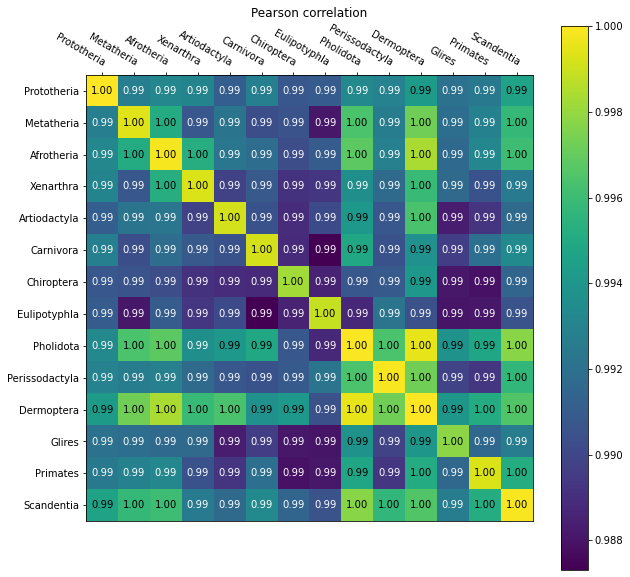

In [17]:
fig,ax = plt.subplots(1,1 , figsize=(10,10))

colThreshold = taxonCorrPearson.min() + ( taxonCorrPearson.max() - taxonCorrPearson.min() ) / 2

heatmap(taxonCorrPearson, taxonLabels, taxonLabels, ax=ax)
ax.set_title("Pearson correlation")
for i in range(len(taxonLabels)):
    for j in range(len(taxonLabels)):
        c = 'k'
        if taxonCorrPearson[i, j] < colThreshold :
            c = 'w'
        text = ax.text(j, i, '{:.2f}'.format(taxonCorrPearson[i, j]) ,
                       ha="center", va="center", color=c)
